# Stock Analysis Using LSTM - MVP (LATEST)
- train an LSTM on a variable number of features
- vary on lookback (LSTM window) and training window (years before present date)
- multi input version
- multi day lookahead (predict x days ahead) version

This notebook adapted from https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

# Import required libraries and set up notebook


In [1]:
! pip install quandl
import pandas as pd
import numpy as np
import os
import yaml
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

# for LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.models import Model
# from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
# access datasets from quandl.com - need to pip install Quandl to use
import quandl
on_colab = False
verboseout = True
look_back = 3
config_file = 'model_training_config.yml'

You are using pip version 19.0.3, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
Using TensorFlow backend.


In [2]:
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
if on_colab:
    %cd /content/drive/MyDrive/karma_jan_2021/stock_investigation/notebooks

# Load config parameters

In [75]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, config_file)
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')

current directory is: C:\personal\karma_stocks_2021\stock_investigation\notebooks
path_to_yaml C:\personal\karma_stocks_2021\stock_investigation\notebooks\model_training_config.yml


In [76]:
# switches
plot_all = config['general']['verboseout']
use_saved_model = config['general']['presaved']
ust_cols = config['general']['ust_cols']
# list of ticket symbols
# e.g. tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
tech_list = config['tech_list']
# dictionary to seed stock handles with company names
# e.g. company_dict = {'AAPL':"APPLE", 'GOOG':"GOOGLE", 'MSFT':"MICROSOFT", 'AMZN':"AMAZON"}
company_dict = config['company_dict']
saved_model_modifier = config['files']['saved_model_modifier']
# get the column lists
continuouscols = config['categorical']
textcols = config['text']
collist = config['continuous']
close_threshold = config['general']['close_threshold']
years_window = config['general']['years_window']
quandl_token = config['general']['quandl_token']
# number of days previous used to predict subsequent day
look_back = config['general']['look_back']
# gap in day betwen the last day previous and the subsequent day being predicted
look_ahead = config['general']['look_ahead']
years_winow = config['general']['years_window']
# target column
lstm_target = config['general']['lstm_target']
# list from target column
lstm_target_list = [lstm_target]
# additional features beyond the target column
feature_list = config['general']['feature_list']
# complete list of features LSTM trained on
lstm_feature_list = lstm_target_list+feature_list
# switch to determine normalization method
min_max_norm = config['general']['min_max_norm']


In [77]:
config

{'general': {'verboseout': False,
  'includetext': True,
  'on_colab': False,
  'presaved': False,
  'savemodel': False,
  'picklemodel': True,
  'save_model_plot': False,
  'tensorboard_callback': False,
  'hctextmax': 7000,
  'maxwords': 6000,
  'textmax': 50,
  'pickled_data_file': '20142018_0930.pkl',
  'pickled_dataframe': 'AB_NYC_2019_output_aug19_2020.pkl',
  'modifier': 'oct05_2020',
  'targetthresh': 6.0,
  'targetcontinuous': False,
  'target_col': 'price',
  'emptythresh': 6000,
  'zero_weight': 1.0,
  'one_weight': 45.878,
  'one_weight_offset': 0,
  'patience_threshold': 3,
  'min_max_norm': True,
  'master_start': '2018-01-01',
  'close_threshold': 0.01,
  'ust_cols': ['2 YR'],
  'years_window': 2,
  'quandl_token': 'uCghYBw8CtpUvWct_W8c',
  'look_back': 3,
  'look_ahead': 7,
  'lstm_target': 'Close',
  'feature_list': ['2 YR',
   '30 YR',
   'Bullish',
   'Bearish',
   'unemployment',
   'gdp',
   'cpi']},
 'files': {'saved_model_modifier': 'January312021'},
 'tech_list'

# Load US Treasury stats

In [7]:
# load US Treasury yield dataframe
ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)

In [8]:
ust_df

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-05,0.04,0.04,0.04,0.07,0.08,0.14,0.32,0.79,1.23,1.56,2.18,2.28
2021-03-08,0.04,0.04,0.05,0.06,0.09,0.17,0.34,0.86,1.28,1.59,2.20,2.31
2021-03-09,0.04,0.04,0.05,0.07,0.10,0.17,0.35,0.83,1.23,1.55,2.16,2.26


In [9]:
# new = old[['A', 'C', 'D']].copy()
ust_df_2year = ust_df[['2 YR']].copy()
ust_df_2year.head()

,2 YR
Date,
1990-01-02,7.87
1990-01-03,7.94
1990-01-04,7.92
1990-01-05,7.90
1990-01-08,7.90


# Load consumer sentiment


In [10]:
# from https://www.quandl.com/data/UMICH/SOC22-University-of-Michigan-Consumer-Survey-Current-Market-Value-of-Primary-Residence
# ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)
# authtoken=quandl_token
conf_df = quandl.get("UMICH/SOC22", authtoken=quandl_token)

In [11]:
conf_df.head()

,Under $100_000,$100_000 - $199_999,$200_000 - $299_999,$300_000 - $399_999,$400_000 - $499_999,$500_000 +,DK; NA,25th Percentile,Median,75th Percentile,Interquartile Range (75th-25th)
Date,,,,,,,,,,,
1990-08-31,60.0,23.0,10.0,1.0,0.0,1.0,5.0,41521.0,75457.0,124447.0,82926.0
1993-11-30,54.0,27.0,7.0,3.0,1.0,3.0,5.0,44000.0,82333.0,149820.0,105820.0
1993-12-31,53.0,28.0,9.0,2.0,1.0,1.0,6.0,50514.0,83693.0,150990.0,100476.0
1994-01-31,57.0,21.0,9.0,4.0,0.0,1.0,8.0,49963.0,80484.0,132046.0,82083.0
1994-02-28,55.0,29.0,7.0,2.0,2.0,2.0,3.0,56000.0,86300.0,148333.0,92333.0


In [12]:
conf_df.tail()

,Under $100_000,$100_000 - $199_999,$200_000 - $299_999,$300_000 - $399_999,$400_000 - $499_999,$500_000 +,DK; NA,25th Percentile,Median,75th Percentile,Interquartile Range (75th-25th)
Date,,,,,,,,,,,
2020-09-30,8.0,19.0,20.0,15.0,9.0,24.0,5.0,176594.0,295738.0,495580.0,318987.0
2020-10-31,8.0,20.0,17.0,16.0,11.0,23.0,5.0,175380.0,300500.0,477137.0,301757.0
2020-11-30,8.0,15.0,21.0,15.0,9.0,26.0,6.0,198333.0,302360.0,501011.0,302677.0
2020-12-31,10.0,17.0,22.0,18.0,9.0,21.0,3.0,180926.0,289556.0,440000.0,259074.0
2021-01-31,8.0,18.0,18.0,17.0,10.0,23.0,6.0,181345.0,300875.0,473333.0,291989.0


In [13]:
conf_df.shape

(202, 11)

# Parameters to incorporate
- Investor sentiment: https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
- GDP: https://www.quandl.com/data/FRED/GDP-Gross-Domestic-Product
- Consumer Price Index (as proxy for inflation): https://www.quandl.com/data/FRED/CPIAUCSL-Consumer-Price-Index-for-All-Urban-Consumers-All-Items (I think these figures are derived from the same source I put in the factor spreadsheet: https://www.bls.gov/news.release/cpi.toc.htm)
- Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate

# Load investor sentiment

In [14]:
# investor sentiment
# https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
# weekly
inv_sent_df = quandl.get("AAII/AAII_SENTIMENT", authtoken=quandl_token)
inv_sent_df.head()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.379783,0.480268,0.279297,NaN,NaN,NaN
1987-07-17,NaN,NaN,NaN,NaN,NaN,NaN,0.379783,0.480268,0.279297,314.59,307.63,314.59
1987-07-24,0.36,0.50,0.14,1.0,NaN,0.22,0.379783,0.480268,0.279297,311.39,307.81,309.27
1987-07-31,0.26,0.48,0.26,1.0,NaN,0.00,0.379783,0.480268,0.279297,318.66,310.65,318.66
1987-08-07,0.56,0.15,0.29,1.0,NaN,0.27,0.379783,0.480268,0.279297,323.00,316.23,323.00


In [15]:
inv_sent_df.tail()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
2021-02-11,0.454545,0.282828,0.262626,0.999999,0.438407,0.191919,0.379783,0.480268,0.279297,3931.50,3816.68,3909.88
2021-02-18,0.470588,0.275542,0.253870,1.000000,0.441332,0.216718,0.379783,0.480268,0.279297,3950.43,3884.94,3931.33
2021-02-25,0.459283,0.302932,0.237785,1.000000,0.442828,0.221498,0.379783,0.480268,0.279297,3924.30,3911.13,3924.30
2021-03-04,0.402597,0.344156,0.253247,1.000000,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20
2021-03-11,0.494118,0.270588,0.235294,1.000000,0.439996,0.258824,0.379783,0.480268,0.279297,3917.35,3885.73,3898.81


In [16]:
inv_sent_df.shape

(1756, 12)

In [17]:
inv_sent_df.index

DatetimeIndex(['1987-06-26', '1987-07-17', '1987-07-24', '1987-07-31',
               '1987-08-07', '1987-08-14', '1987-08-21', '1987-08-28',
               '1987-09-04', '1987-09-11',
               ...
               '2020-12-31', '2021-01-07', '2021-01-21', '2021-01-28',
               '2021-02-04', '2021-02-11', '2021-02-18', '2021-02-25',
               '2021-03-04', '2021-03-11'],
              dtype='datetime64[ns]', name='Date', length=1756, freq=None)

In [18]:
# infill weekly time series to daily
# try  resample approach: https://stackoverflow.com/questions/55901304/pandas-resample-from-weekly-to-daily-with-offset
# df = df.resample('D', loffset=offset).ffill()
inv_sent_df2 = inv_sent_df.resample('D').ffill()

inv_sent_df2

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.379783,0.480268,0.279297,NaN,NaN,NaN
1987-06-27,NaN,NaN,NaN,NaN,NaN,NaN,0.379783,0.480268,0.279297,NaN,NaN,NaN
1987-06-28,NaN,NaN,NaN,NaN,NaN,NaN,0.379783,0.480268,0.279297,NaN,NaN,NaN
1987-06-29,NaN,NaN,NaN,NaN,NaN,NaN,0.379783,0.480268,0.279297,NaN,NaN,NaN
1987-06-30,NaN,NaN,NaN,NaN,NaN,NaN,0.379783,0.480268,0.279297,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-07,0.402597,0.344156,0.253247,1.0,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20
2021-03-08,0.402597,0.344156,0.253247,1.0,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20
2021-03-09,0.402597,0.344156,0.253247,1.0,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20


In [19]:

ust_df.shape

(7803, 12)

# Load GDP

In [20]:
gdp_df = quandl.get("FRED/GDP", authtoken=quandl_token)
gdp_df.tail()

,Value
Date,
2019-10-01,21747.394
2020-01-01,21561.139
2020-04-01,19520.114
2020-07-01,21170.252
2020-10-01,21487.896


In [21]:
gdp_df.rename(columns={'Value':'gdp'}, inplace=True)
gdp_df.tail()

,gdp
Date,
2019-10-01,21747.394
2020-01-01,21561.139
2020-04-01,19520.114
2020-07-01,21170.252
2020-10-01,21487.896


In [22]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-03-12')

In [23]:
gdp_df.loc[add_date] = [21487.896]

In [24]:
gdp_df = gdp_df.resample('D').ffill()
gdp_df.tail()

,gdp
Date,
2021-03-08,21487.896
2021-03-09,21487.896
2021-03-10,21487.896
2021-03-11,21487.896
2021-03-12,21487.896


# Load CPI

In [25]:
cpi_df = quandl.get("FRED/CPIAUCSL", authtoken=quandl_token)
cpi_df.tail()

,Value
Date,
2020-10-01,260.462
2020-11-01,260.927
2020-12-01,261.560
2021-01-01,262.231
2021-02-01,263.161


In [26]:
cpi_df.rename(columns={'Value':'cpi'}, inplace=True)

In [27]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-03-12')

In [28]:
cpi_df.loc[add_date] = [262.231]

In [29]:
cpi_df = cpi_df.resample('D').ffill()
cpi_df.tail()

,cpi
Date,
2021-03-08,263.161
2021-03-09,263.161
2021-03-10,263.161
2021-03-11,263.161
2021-03-12,262.231


# Load unemployment

In [30]:
# Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate
# monthly
unemp_df = quandl.get("FRED/UNRATE")
unemp_df.tail()

,Value
Date,
2020-10-01,6.9
2020-11-01,6.7
2020-12-01,6.7
2021-01-01,6.3
2021-02-01,6.2


In [31]:
unemp_df.rename(columns={'Value':'unemployment'}, inplace=True)

In [32]:
unemp_df.index

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01'],
              dtype='datetime64[ns]', name='Date', length=878, freq=None)

In [33]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-03-12')

In [34]:
unemp_df.loc[add_date] = [6.2]

In [35]:
unemp_df.tail()

,unemployment
Date,
2020-11-01,6.7
2020-12-01,6.7
2021-01-01,6.3
2021-02-01,6.2
2021-03-12,6.2


In [36]:
unemp_df = unemp_df.resample('D').ffill()
unemp_df.tail()

,unemployment
Date,
2021-03-08,6.2
2021-03-09,6.2
2021-03-10,6.2
2021-03-11,6.2
2021-03-12,6.2


In [37]:
unemp_df.shape

(26735, 1)

# Join input dataframes

In [38]:
# do an inner join on Date column
ust_df = pd.merge(ust_df,inv_sent_df2,on=['Date'],how='inner')
ust_df.head() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,...,0.34,1.0,0.31250,0.01,0.379783,0.480268,0.279297,353.40,346.81,353.4
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,...,0.34,1.0,0.31250,0.01,0.379783,0.480268,0.279297,353.40,346.81,353.4
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,...,0.34,1.0,0.31250,0.01,0.379783,0.480268,0.279297,353.40,346.81,353.4
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,...,0.30,1.0,0.32875,0.10,0.379783,0.480268,0.279297,359.69,352.20,352.2
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,...,0.30,1.0,0.32875,0.10,0.379783,0.480268,0.279297,359.69,352.20,352.2


In [39]:
ust_df = pd.merge(ust_df,unemp_df,on=['Date'],how='inner')
ust_df.tail() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-05,0.04,0.04,0.04,0.07,0.08,0.14,0.32,0.79,1.23,1.56,...,1.0,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2
2021-03-08,0.04,0.04,0.05,0.06,0.09,0.17,0.34,0.86,1.28,1.59,...,1.0,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2
2021-03-09,0.04,0.04,0.05,0.07,0.10,0.17,0.35,0.83,1.23,1.55,...,1.0,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2
2021-03-10,0.03,0.03,0.04,0.06,0.08,0.16,0.32,0.80,1.20,1.53,...,1.0,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2
2021-03-11,0.04,0.04,0.04,0.05,0.08,0.14,0.31,0.78,1.20,1.54,...,1.0,0.439996,0.258824,0.379783,0.480268,0.279297,3917.35,3885.73,3898.81,6.2


In [40]:
ust_df = pd.merge(ust_df,gdp_df,on=['Date'],how='inner')
ust_df.head() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,...,0.31250,0.01,0.379783,0.480268,0.279297,353.40,346.81,353.4,5.4,5872.701
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,...,0.31250,0.01,0.379783,0.480268,0.279297,353.40,346.81,353.4,5.4,5872.701
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,...,0.31250,0.01,0.379783,0.480268,0.279297,353.40,346.81,353.4,5.4,5872.701
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,...,0.32875,0.10,0.379783,0.480268,0.279297,359.69,352.20,352.2,5.4,5872.701
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,...,0.32875,0.10,0.379783,0.480268,0.279297,359.69,352.20,352.2,5.4,5872.701


In [41]:
ust_df.tail()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-05,0.04,0.04,0.04,0.07,0.08,0.14,0.32,0.79,1.23,1.56,...,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2,21487.896
2021-03-08,0.04,0.04,0.05,0.06,0.09,0.17,0.34,0.86,1.28,1.59,...,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2,21487.896
2021-03-09,0.04,0.04,0.05,0.07,0.10,0.17,0.35,0.83,1.23,1.55,...,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2,21487.896
2021-03-10,0.03,0.03,0.04,0.06,0.08,0.16,0.32,0.80,1.20,1.53,...,0.439733,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2,21487.896
2021-03-11,0.04,0.04,0.04,0.05,0.08,0.14,0.31,0.78,1.20,1.54,...,0.439996,0.258824,0.379783,0.480268,0.279297,3917.35,3885.73,3898.81,6.2,21487.896


In [42]:
ust_df.shape

(7803, 26)

In [43]:
ust_df = pd.merge(ust_df,cpi_df,on=['Date'],how='inner')
ust_df.tail() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp,cpi
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-05,0.04,0.04,0.04,0.07,0.08,0.14,0.32,0.79,1.23,1.56,...,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2,21487.896,263.161
2021-03-08,0.04,0.04,0.05,0.06,0.09,0.17,0.34,0.86,1.28,1.59,...,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2,21487.896,263.161
2021-03-09,0.04,0.04,0.05,0.07,0.10,0.17,0.35,0.83,1.23,1.55,...,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2,21487.896,263.161
2021-03-10,0.03,0.03,0.04,0.06,0.08,0.16,0.32,0.80,1.20,1.53,...,0.149350,0.379783,0.480268,0.279297,3837.96,3817.26,3837.20,6.2,21487.896,263.161
2021-03-11,0.04,0.04,0.04,0.05,0.08,0.14,0.31,0.78,1.20,1.54,...,0.258824,0.379783,0.480268,0.279297,3917.35,3885.73,3898.81,6.2,21487.896,263.161


# Define start and end of analysis period

In [44]:
# DataReader: https://riptutorial.com/pandas/topic/1912/pandas-datareader
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
# 
# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - years_window, end.month, end.day)
tester = DataReader('AAPL', 'yahoo', start, end)
tester.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-12,45.667500,44.842499,45.000000,45.227501,129870400.0,44.299774
2019-03-13,45.825001,45.230000,45.562500,45.427502,124130000.0,44.495667
2019-03-14,46.025002,45.639999,45.974998,45.932499,94318000.0,44.990303
2019-03-15,46.832500,45.935001,46.212502,46.529999,156171600.0,45.575550
2019-03-18,47.097500,46.447498,46.450001,47.005001,104879200.0,46.040817


# Main model definition
- build dataframe containing all features
- define helper functions
- run main blocks to define and train model
- run block to visualize predictions

# Block to define main dataframe
- combine closing data dataframe with additional time series data (e.g. from quandl)

In [45]:
#Get the stock quote
# tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
df_predict = {}
# start='2012-01-01'
for company in tech_list:
    df_predict[company] = DataReader(company,data_source='yahoo', start=start, end=datetime.now())
    # ezj["close"] / ezj["close"].shift() - 1
    df_predict[company]['Return'] = df_predict[company]['Close']/df_predict[company]['Close'].shift() -1
    df_predict[company]['Return'] = df_predict[company]['Return'].fillna(0.0)
    # check if anything being joined
    if len(feature_list) > 0:
        df_predict[company] = pd.merge(df_predict[company],ust_df[feature_list],on=['Date'],how='inner')
    # add
    # show an example
df_predict[tech_list[0]].head()

,High,Low,Open,Close,Volume,Adj Close,Return,2 YR,30 YR,Bullish,Bearish,unemployment,gdp,cpi
Date,,,,,,,,,,,,,,
2019-03-12,25.049999,24.459999,24.930000,24.900000,1117200,24.900000,0.000000,2.45,3.00,0.373860,0.267477,3.8,21115.309,254.147
2019-03-13,25.250000,24.889999,24.889999,25.049999,1318900,25.049999,0.006024,2.45,3.02,0.373860,0.267477,3.8,21115.309,254.147
2019-03-14,25.100000,24.719999,25.040001,24.830000,794600,24.830000,-0.008782,2.46,3.04,0.324232,0.310580,3.8,21115.309,254.147
2019-03-15,25.150000,24.629999,24.850000,24.920000,2136000,24.920000,0.003625,2.43,3.02,0.324232,0.310580,3.8,21115.309,254.147
2019-03-18,25.799999,24.590000,24.690001,25.740000,1198900,25.740000,0.032905,2.45,3.01,0.324232,0.310580,3.8,21115.309,254.147


# Define helper functions
- define helper functions used by main model training block

In [46]:
def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [47]:
def save_model(model,company):
    '''save the model to a file in directory models that is a peer of the directory containing this notebook'''
    model_path = get_model_path()
    modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    model.save(save_model_path)
    # no early stop, so make current model saved_model
    print("Saved model with name ",company+modifier+'.h5')
    


In [48]:
def get_save_model_path(company):
    model_path = get_model_path()
    modifier = saved_model_modifier
    # modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    return(save_model_path)

In [49]:
def one_col_df(df,col):
    data = df.filter([col])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [50]:
def multi_col_df(df,cols):
    print("cols is:", cols)
    #data = df.filter(cols)
    data = df[cols]
    #print("data inside is:",data)
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [51]:
def get_keras_vars(dataset):
    '''cribbed from traditional DL on structured data code'''
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

In [52]:
def scale_data(dataset):
    if min_max_norm:
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(dataset)
    else:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(dataset)
    return(scaled_data,scaler)

In [53]:
def create_x_y(scaled_data,training_data_len,look_back,input_col_count):
    '''convert scaled dataset into numpy x and y arrays for training'''
    #Create the training data set
    #Create the scaled training data set
    print("scaled_data shape: ",str(scaled_data.shape))
    print('training_data_len: ',training_data_len)
    train_data = scaled_data[0:int(training_data_len), :]
    print("train_data shape is: ",train_data.shape)
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    print("len(train_data): ",str(len(train_data)))
    # here, each x is a set of look_back values and each y is the next value
    # a = dataset[i:(i + look_back), :]
    for i in range(len(train_data) - look_back - look_ahead - 1):
        a = train_data[i:(i + look_back), :]
        x_train.append(a)
        y_train.append(train_data[i+look_ahead, 0])
        

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return(x_train,y_train)

In [54]:
def build_model(x_train,y_train,optimizer,loss_function):
        '''build simple model given x, y, optimizer and loss function - sequential API'''
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [55]:
def build_model_func(x_train,y_train,optimizer,loss_function,input_dim):
        '''build simple model given x, y, optimizer and loss function - functional API'''
        '''reference https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
            and https://stackoverflow.com/questions/42532386/how-to-work-with-multiple-inputs-for-lstm-in-keras'''
        lstminputs = {}
        inputlayerlist = []
        col = "holder"
        #lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        lstminputs[col] = Input(shape=(x_train.shape[1],input_dim),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        
        #output = Dense(1, activation=output_activation) (lstminputs[col])
        output = Dense(1) (lstminputs[col])
        # define model

        model = Model(inputlayerlist, output)

        
        
 
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [56]:
def build_model_func2(x_train,y_train,optimizer,loss_function,collist,continuouscols,lstmcols):
    '''build multi-input functional API model
    collist - list of categorical columns
    continuouscols - list of continuous columns
    
    want to have x_train being a list of numpy arrays, 
    one for each column that we want to create layers for
    
    
    
    '''
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    lstminput = {} # list of lstm inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    inputlayerlist = []
    

    
    '''
    for col in lstmcols:
        lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        # question here whether to include a dense layer or not at the end of LSTM 
        '''
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
        
    return(model)

In [57]:
# from https://stackoverflow.com/questions/53049396/sklearn-inverse-transform-return-only-one-column-when-fit-to-many
def invTransform(scaler, data, colName, colNames):
    # wrapper function to get inverse transform on one column from a dataframe that has been scaled
    # - scaler   = the scaler object (it needs an inverse_transform method)
    # - data     = the data to be inverse transformed as a Series, ndarray, ... 
    #              (a 1d object you can assign to a df column)
    # - ftName   = the name of the column to which the data belongs
    # - colNames = all column names of the data on which scaler was fit 
    #              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

# Main model definition and training block

In [58]:
%%time
# train models for each company in tech_list and save trained models
predictions = {}
data = {}
for company in tech_list:
    data[company],dataset,training_data_len = multi_col_df(df_predict[company],lstm_feature_list)
    # X, dictlist get_keras_vars(df_predict[company])
    #print("dataset is: ",dataset)
    #print(("data[company] is:",data[company]))
    print("training_data_len: ",training_data_len)
    print("dataset shape: ",str(dataset.shape))
    print("data[company] shape: ",str(data[company].shape))
    #scaled_data, scaler = scale_data(dataset)
    scaled_data, scaler = scale_data(data[company])
    x_train, y_train = create_x_y(scaled_data,training_data_len,look_back,len(lstm_feature_list))
    #print("x_train is: ",x_train)
    #print("y_train is: ",y_train)
    print("x_train shape: ",x_train.shape)
    print("y_train shape: ",y_train.shape)
    print("TRAINING LOOP FOR: ",str(company))
    '''
    turn off for experiment with multi columns
    '''
    if use_saved_model:
        # put here
        save_model_path = get_save_model_path(company)
        model = load_model(save_model_path)
    else:
        # train model fresh
        #Build the LSTM model
        model = build_model_func(x_train,y_train,'adam','mean_squared_error',len(lstm_feature_list))
        # save the model
        save_model(model,company)
    #Create a new array containing scaled values from index 1543 to 2002 
    
    test_data = scaled_data[training_data_len - look_back: , :]
    #Create the data sets x_test and y_test
    print("about to run test loop")
    x_test = []
    y_test = []
    # y_test = dataset[training_data_len:, :]
    for i in range(len(test_data)-look_ahead):
        y_test.append(test_data[i+look_ahead, 0])
    
    
    
    print("look_back is", look_back)
    print("shape of test_data is ",str(test_data.shape))
    print("len(test_data) is ",len(test_data))
    for i in range(look_back,len(test_data)):
        a = test_data[i-look_back:i, :]
        x_test.append(a)
    print("shape of a is ",str(a.shape))
    print("after test loop")
    '''
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    '''
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    print("x_test shape",x_test.shape)
    print("y_test shape",y_test.shape)
    # Reshape the data
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions_temp = model.predict(x_test)
    print("after predictions_temp")
    print("predictions temp shape ",predictions_temp.shape)
    #print("prediction_temp: ",predictions_temp)
    # invTransform(scaler, data, colName, colNames)
    # predictions[company] = scaler.inverse_transform(predictions_temp)
    predictions[company] = invTransform(scaler,predictions_temp,lstm_target,lstm_feature_list)
    print("predictions company shape ",predictions[company].shape)
    predictions[company] = np.reshape(predictions[company], (predictions[company].shape[0],1))
    print("predictions company shape 2 ",predictions[company].shape)
    

cols is: ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
training_data_len:  401
dataset shape:  (501, 8)
data[company] shape:  (501, 8)
scaled_data shape:  (501, 8)
training_data_len:  401
train_data shape is:  (401, 8)
len(train_data):  401
x_train shape:  (390, 3, 8)
y_train shape:  (390,)
TRAINING LOOP FOR:  CROX
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/1
390/390 [==============================] - 3s 8ms/step - loss: 0.0055
Saved model with name  CROXMarch122021.h5
about to run test loop
look_back is 3
shape of test_data is  (103, 8)
len(test_data) is  103
shape of a is  (3, 8)
after test loop
x_test shape (100, 3, 8)
y_test shape (96,)
after predictions_temp
predictions temp shape  (100, 1)
predictions company shape  (100,)
predictions company shape 2  (100, 1)
cols is: ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
training_data_len:  401
dataset shape:  (501, 8)
data[c

In [59]:
x_test

array([[[0.40376594, 0.02953586, 0.28780488, ..., 0.30088496,
         0.88349107, 0.70057688],
        [0.4066158 , 0.02953586, 0.25853659, ..., 0.30088496,
         0.88349107, 0.70057688],
        [0.39175576, 0.02109705, 0.24878049, ..., 0.30088496,
         0.88349107, 0.70057688]],

       [[0.4066158 , 0.02953586, 0.25853659, ..., 0.30088496,
         0.88349107, 0.70057688],
        [0.39175576, 0.02109705, 0.24878049, ..., 0.30088496,
         0.88349107, 0.70057688],
        [0.39094149, 0.02109705, 0.25853659, ..., 0.30088496,
         0.88349107, 0.70057688]],

       [[0.39175576, 0.02109705, 0.24878049, ..., 0.30088496,
         0.88349107, 0.70057688],
        [0.39094149, 0.02109705, 0.25853659, ..., 0.30088496,
         0.88349107, 0.70057688],
        [0.3843257 , 0.02109705, 0.25853659, ..., 0.30088496,
         0.88349107, 0.70057688]],

       ...,

       [[0.78229015, 0.02109705, 0.63902439, ..., 0.23893805,
         0.88349107, 1.        ],
        [0.81679396, 

# Plotting block
- for each model trained, plot the actual for history and, for validation period, actual vs. prediciton
- display key parameters

In [60]:
#def create_summary_table(summary_df):
#    return("what")

SyntaxError: unexpected EOF while parsing (<ipython-input-60-251d86649e5d>, line 2)

c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


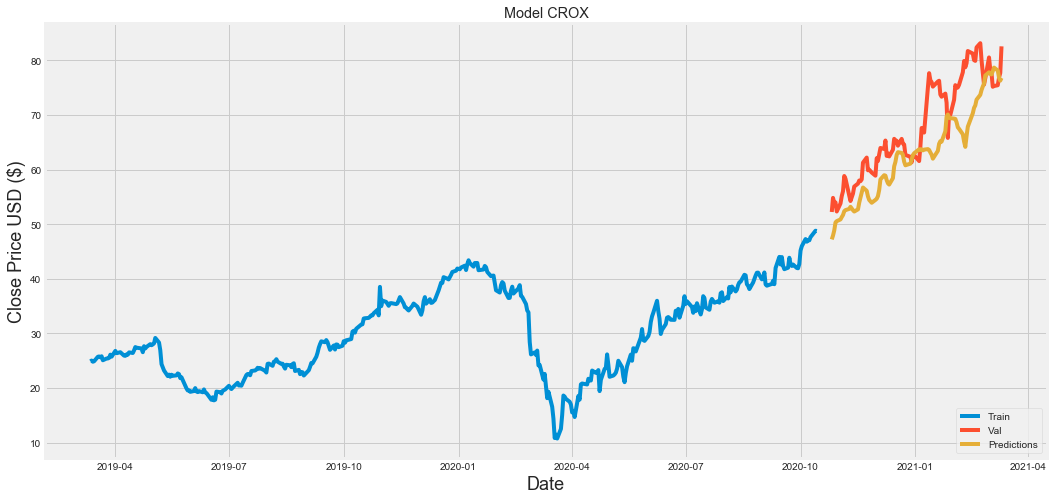

LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
lookback is:  3
lookahead is:  7
years_window is:  2
length of test window:  103
normalization method:  min_max
  ticker  total error  avg error  max error  proportion good days
0   CROX     4.591598   4.937202   0.147393                  0.11


c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


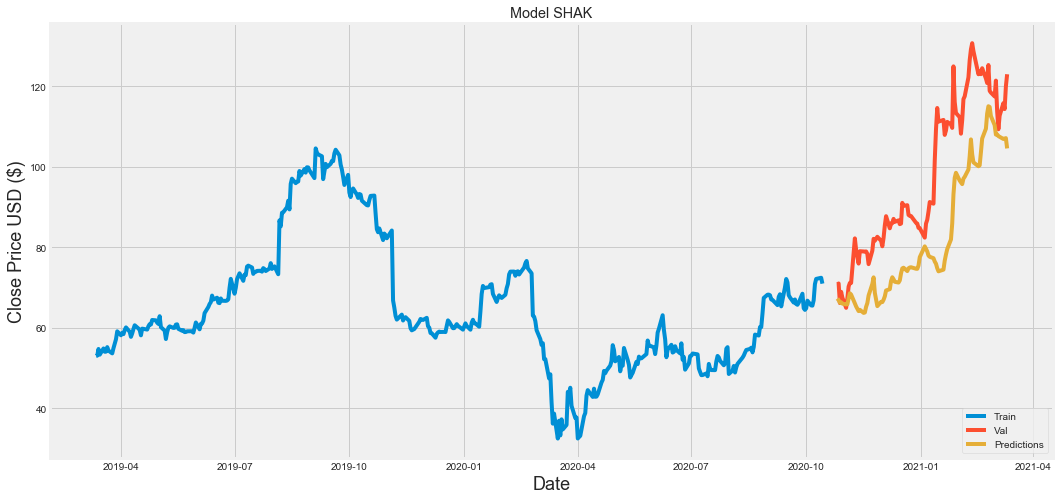

LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
lookback is:  3
lookahead is:  7
years_window is:  2
length of test window:  103
normalization method:  min_max
  ticker  total error  avg error  max error  proportion good days
0   CROX     4.591598   4.937202   0.147393                  0.11
1   SHAK    13.612496  14.637093   0.398144                  0.02


In [85]:
# Plot the data

summary_df = pd.DataFrame(columns=['ticker','total error','avg error','max error','proportion good days'])
for company in tech_list:
    summary_dict = {}
    train = data[company][:training_data_len]
    #valid = data[company][training_data_len:]
    valid = data[company][training_data_len+look_ahead:]
    #train = np.reshape(train,(train.shape[0],1))
    #valid = np.reshape(valid,(valid.shape[0],1))
    #print("train shape ",train.shape)
    #print("valid shape ",valid.shape)
    #print("predictions[company] shape ",predictions[company].shape)
    #print("things you want ",str(predictions[company].shape[0]-look_ahead))
    valid['Predictions'] = predictions[company][:predictions[company].shape[0]-look_ahead]
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model'+" "+company)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(lstm_target+' Price USD ($)', fontsize=18)
    plt.plot(train[lstm_target])
    plt.plot(valid[[lstm_target, 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    print("LSTM target is: ",lstm_target)
    print("LSTM features are: ",lstm_feature_list)
    print("lookback is: ",str(look_back))
    print("lookahead is: ",str(look_ahead))
    print("years_window is: ",str(years_window))
    print("length of test window: ",len(test_data))
    if min_max_norm:
        norm = "min_max"
    else:
        norm = "standardization"
    print("normalization method: ",norm)
    # df[df > 1.0].count()
    # ['ticker','total error','avg error','max error','proportion good days']
    valid['error'] = valid[lstm_target] - valid['Predictions']
    summary_dict['ticker'] = company
    summary_dict['total error'] = valid['error'].sum()/predictions[company].shape[0]
    summary_dict['avg error'] = valid['error'].mean()
    summary_dict['max error'] = valid['error'].max()/predictions[company].shape[0]
    summary_dict['proportion good days'] = valid['error'][valid['error'] <= close_threshold].count()/predictions[company].shape[0]
    summary_df = summary_df.append(summary_dict , ignore_index=True)
    print(" ")
    print(summary_df)

In [83]:
summary_df.head()

,ticker,total error,avg error,max error,proportion good days
0,CROX,4.591598,4.937202,0.147393,0.11
1,SHAK,13.612496,14.637093,0.398144,0.02
